In [2]:
# ! rm -rvf /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset
# from setup_scripts.download_dataset import main; main()
# from setup_scripts.unzip_dataset import main; main()
# from setup_scripts.extract_images import main; main()

## Library Imports

In [3]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import bts.dataset as dataset
import bts.model as model
import bts.classifier as classifier
import bts.plot as plot

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

Computation Details
	Device Used: (cuda:1)  NVIDIA RTX A5000

Packages Used Versions:-
	Pytorch Version: 2.1.2


In [4]:
# Dataset part used for testing
TEST_SPLIT = 0.2

# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6

# Dataset folder used
DATASET_USED = 'png_dataset'

# Full Dataset path
target_folder = '/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset'
DATASET_PATH = os.path.join(target_folder, 'png_dataset')

# Training Epochs
EPOCHS = 10

# Filters used in UNet Model
FILTER_LIST = [16,32,64,128,256]

# Flag to train the model
TRAIN = True

# Flag to load saved model
LOAD_MODEL = False

# Flag to save model trained
SAVE_MODEL = True

# Model name to save or load.
MODEL_NAME = f"UNet-{FILTER_LIST}_{EPOCHS}.pt"

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet-[16, 32, 64, 128, 256]_10.pt


## Dataset Loading

In [5]:
def get_indices(length, new=False):
    """ Gets the Training & Testing data indices for a
    paticular "DATASET_USED".Stores the indices and returns
    them back when the same dataset is used.
    Parameters:
        length(int): Length of the dataset used.
        new(bool): Discard the saved indices and get new ones.
    Return:
        train_indices(list): Array of indices used for training purpose.
        test_indices(list): Array of indices used for testing purpose.
    """
    # Pickle file location of the indices.
    file_path = os.path.join(target_folder,f'split_indices_{DATASET_USED}.p')
    data = dict()
    if os.path.isfile(file_path) and not new:
        # File found.
        with open(file_path,'rb') as file :
            data = pickle.load(file)
            return data['train_indices'], data['test_indices']
    else:
        # File not found or fresh copy is required.
        indices = list(range(length))
        np.random.shuffle(indices)
        split = int(np.floor(TEST_SPLIT * len(tumor_dataset)))
        train_indices , test_indices = indices[split:], indices[:split]
        # Indices are saved with pickle.
        data['train_indices'] = train_indices
        data['test_indices'] = test_indices
        with open(file_path,'wb') as file:
            pickle.dump(data,file)
    return train_indices, test_indices

In [6]:
tumor_dataset = dataset.TumorDataset(DATASET_PATH)

train_indices, test_indices = get_indices(len(tumor_dataset))
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

## Model Initialization

In [7]:
unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    # New model is created.
    unet_model = model.DynamicUNet(FILTER_LIST).to(device)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    print('New model is created')
else:
    # Saved model is loaded on memory.
    unet_model = model.DynamicUNet(FILTER_LIST)
    unet_classifier = classifier.BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

New model is created


## Model Training

In [8]:
# Training process
if TRAIN:
    unet_model.train()
    path = os.path.join('saved_models',MODEL_NAME) if SAVE_MODEL else None
    unet_train_history = unet_classifier.train(EPOCHS,trainloader,mini_batch=100,save_best=path)
    print(f'Training Finished after {EPOCHS} epoches')

# Testing process on test data.
unet_model.eval()
unet_score = unet_classifier.test(testloader)
print(f'\n\nDice Score {unet_score}')
# Dice Score 0.7446110107881675

Starting Training Process
    Batch: 100,	Batch Loss: 0.1871739
    Batch: 200,	Batch Loss: 0.1668968
    Batch: 300,	Batch Loss: 0.1609971
    Batch: 400,	Batch Loss: 0.1653493
Epoch: 001,  Loss:0.1699883,  Time:135.78secs	Saved at loss: 0.1699882529
    Batch: 100,	Batch Loss: 0.1590527
    Batch: 200,	Batch Loss: 0.1532513
    Batch: 300,	Batch Loss: 0.1561562
    Batch: 400,	Batch Loss: 0.1508092
Epoch: 002,  Loss:0.1546880,  Time:49.72secs	Saved at loss: 0.1546879529
    Batch: 100,	Batch Loss: 0.1517950
    Batch: 200,	Batch Loss: 0.1491668
    Batch: 300,	Batch Loss: 0.1462983
    Batch: 400,	Batch Loss: 0.1465836
Epoch: 003,  Loss:0.1482785,  Time:51.07secs	Saved at loss: 0.1482784685
    Batch: 100,	Batch Loss: 0.1445695
    Batch: 200,	Batch Loss: 0.1444747
    Batch: 300,	Batch Loss: 0.1497984
    Batch: 400,	Batch Loss: 0.1453560
Epoch: 004,  Loss:0.1458062,  Time:42.81secs	Saved at loss: 0.1458061939
    Batch: 100,	Batch Loss: 0.1409325
    Batch: 200,	Batch Loss: 0.14482

## Training Results

### Training Loss Graph

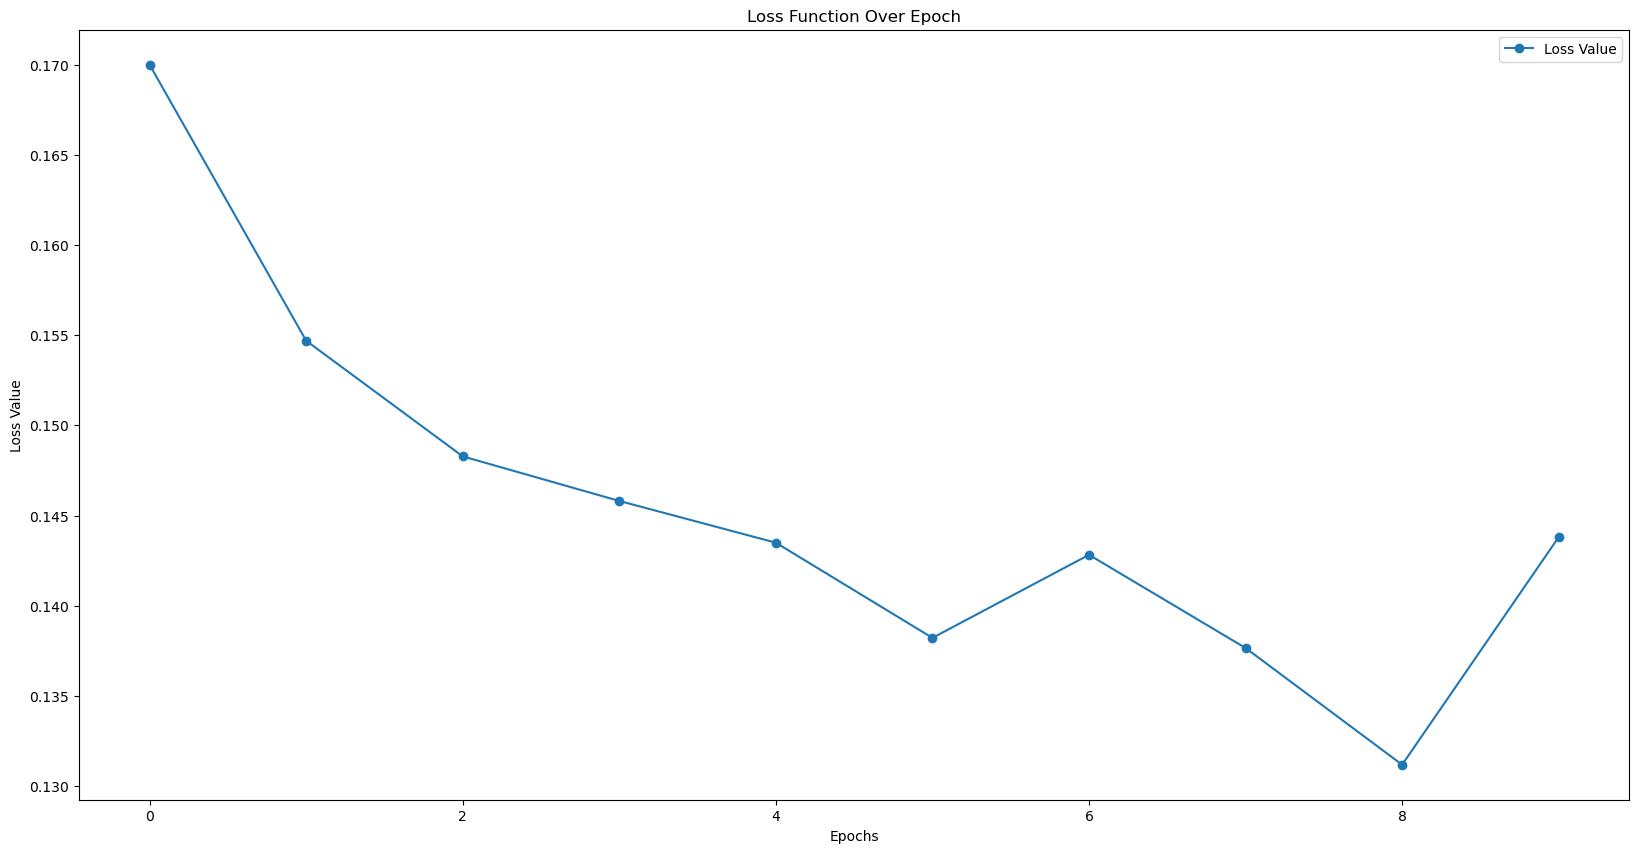

In [9]:
save_plot = os.path.join('images',f'{MODEL_NAME}-loss_graph.png')
plot.loss_graph(unet_train_history['train_loss'],save_plot)

### Visualize Test Dataset Predictions

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_2.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png


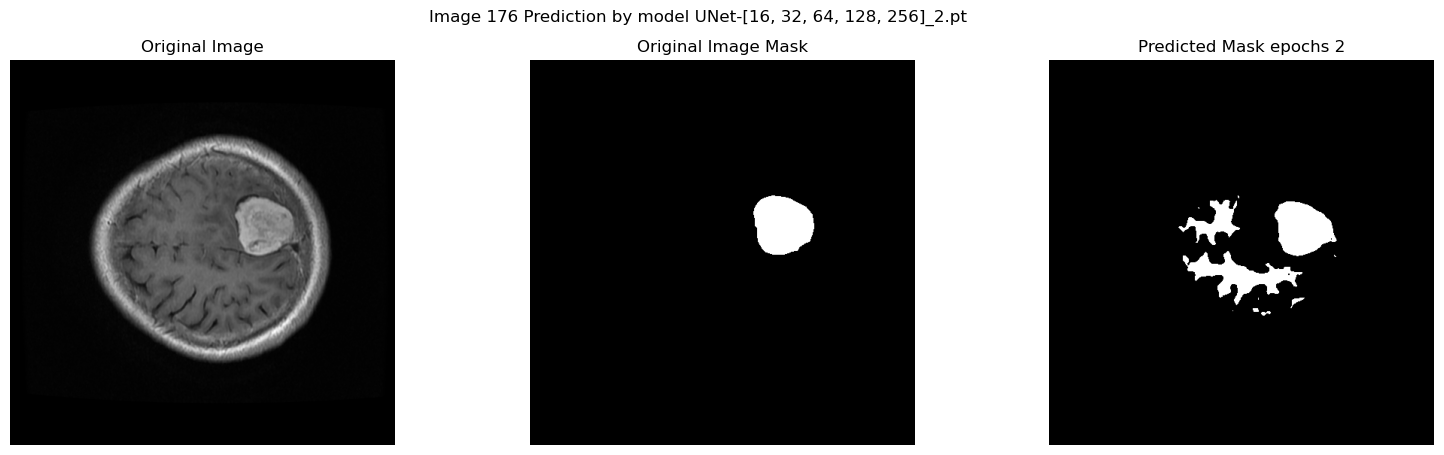

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_10.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png


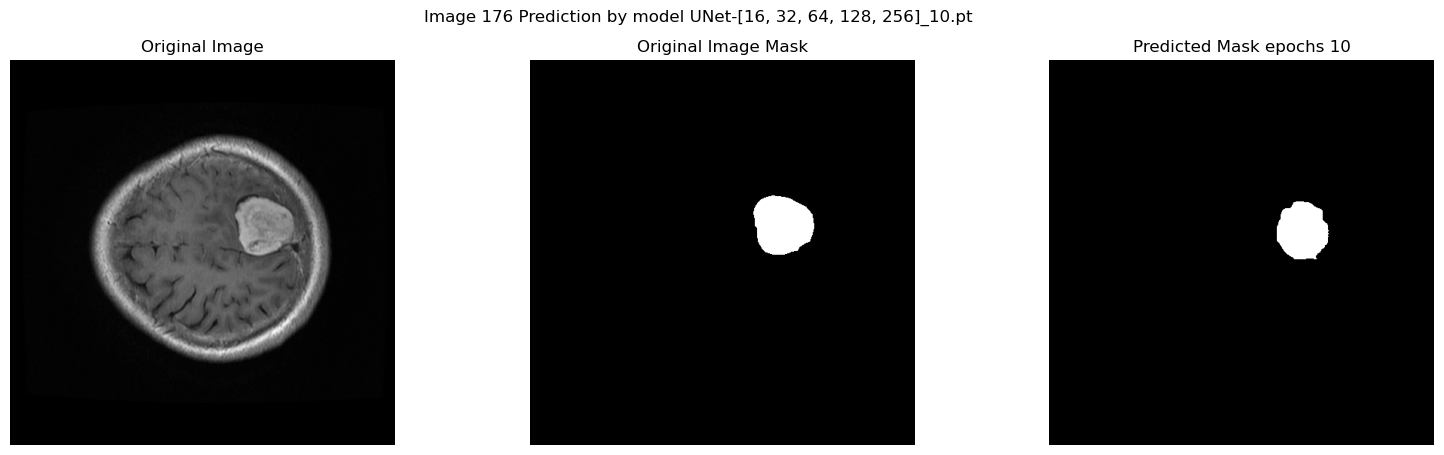

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_100.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/176_predicted.png


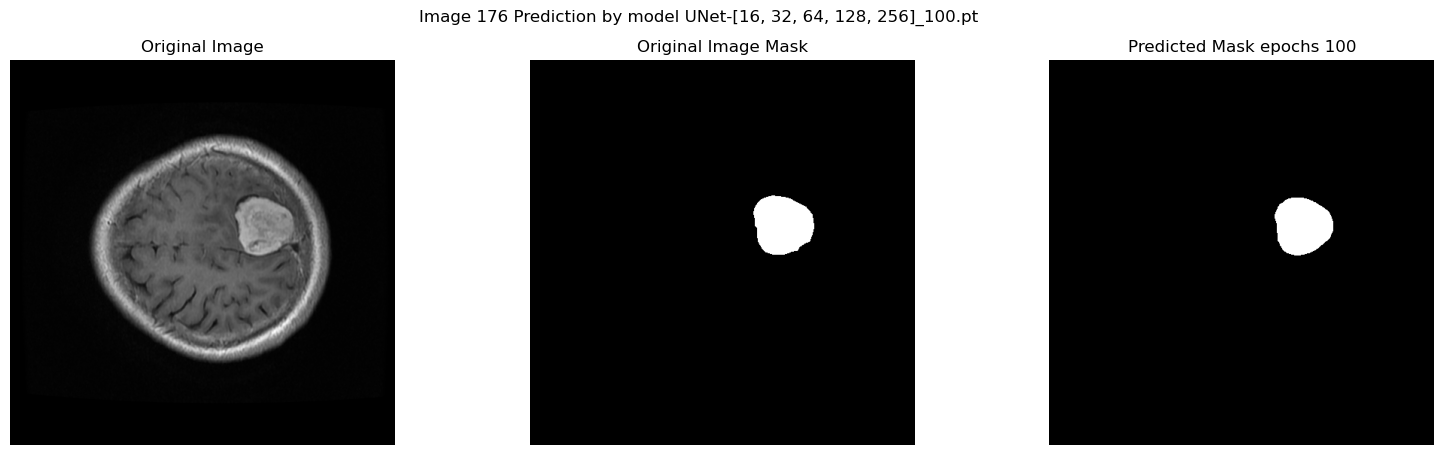

In [10]:
plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_2.pt"
! python api.py --ep 2 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/176.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 176

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 2")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_10.pt"
! python api.py --ep 10 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/176.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 176

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 10")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_100.pt"
! python api.py --ep 100 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/176.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 176

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 100")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_2.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png


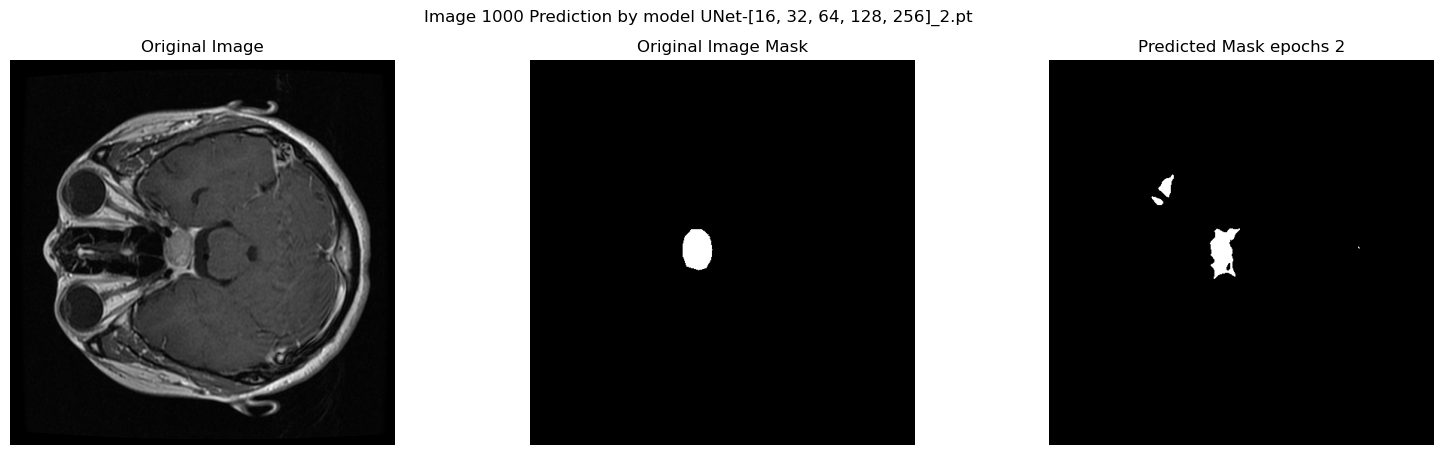

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_10.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png


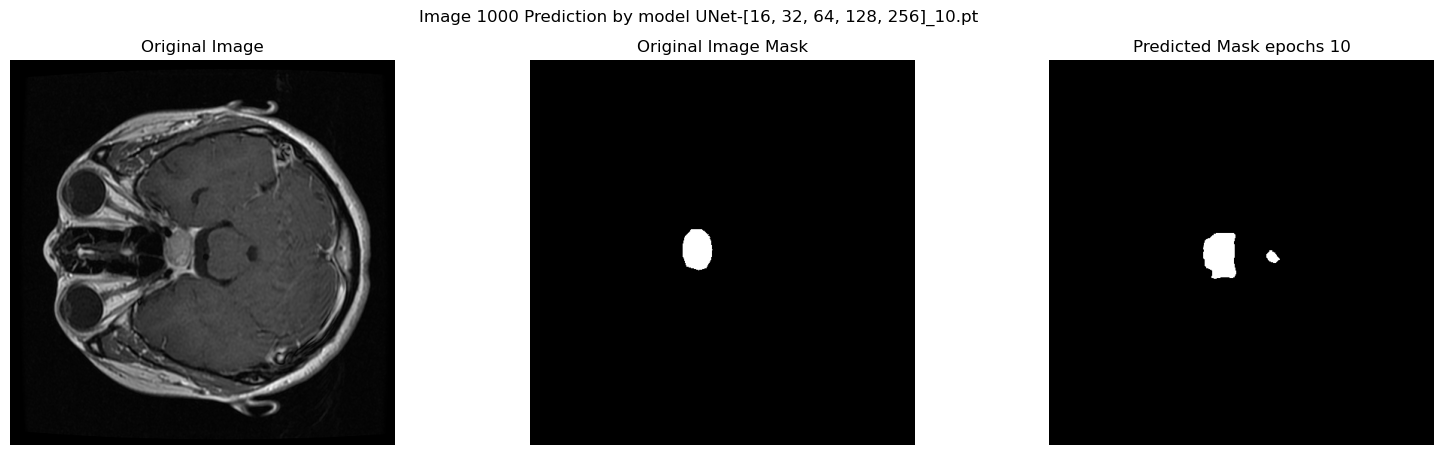

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_100.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/1000_predicted.png


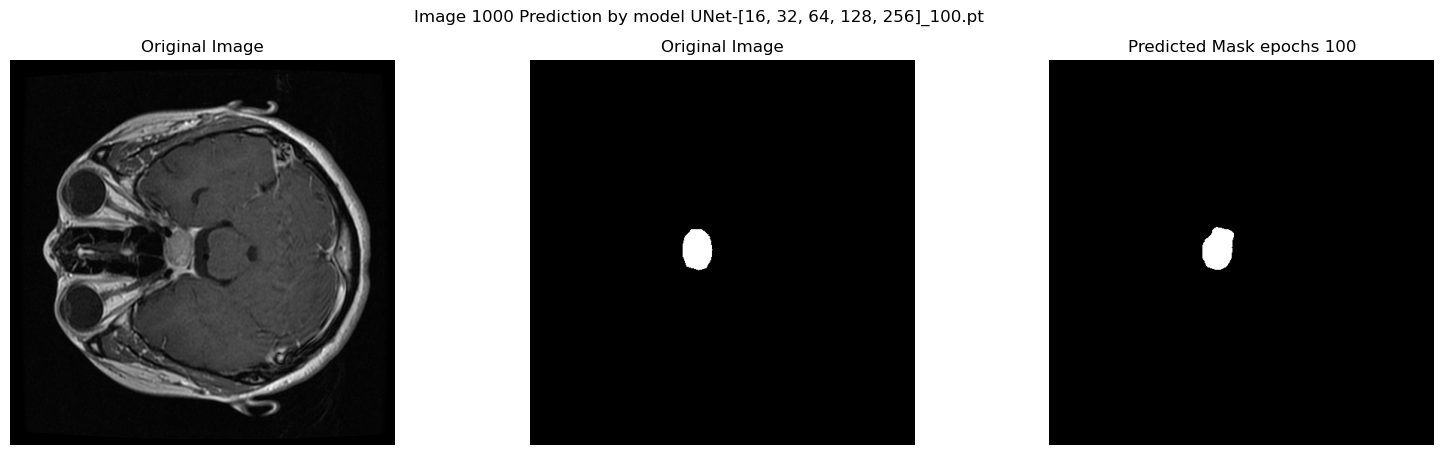

In [11]:
plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_2.pt"
! python api.py --ep 2 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/1000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 1000

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 2")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_10.pt"
! python api.py --ep 10 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/1000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 10")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_100.pt"
! python api.py --ep 100 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/1000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions


org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 100")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_2.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png


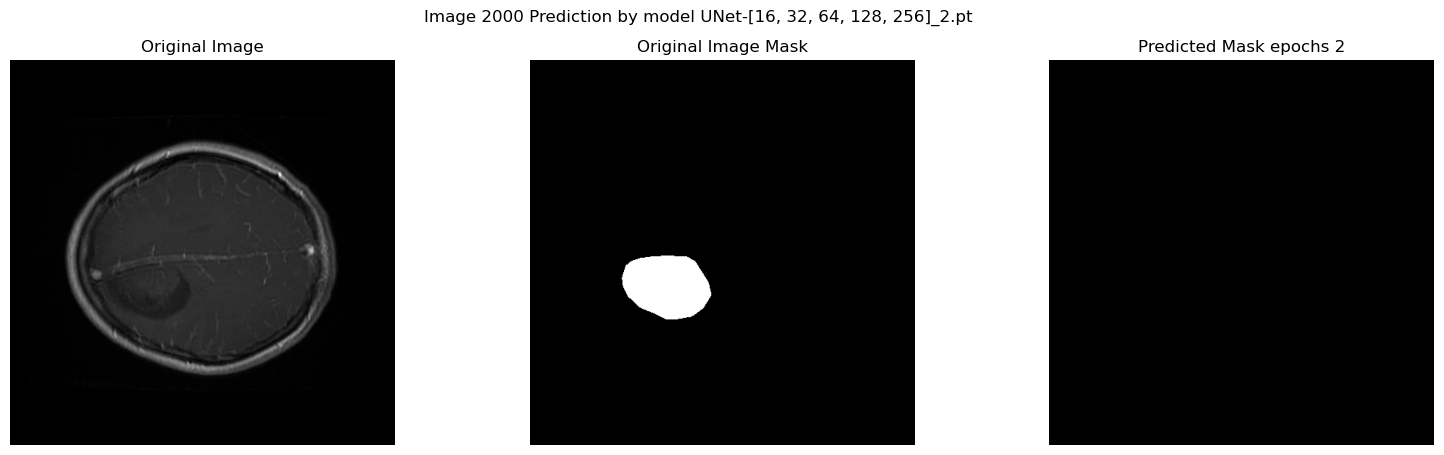

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_10.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png


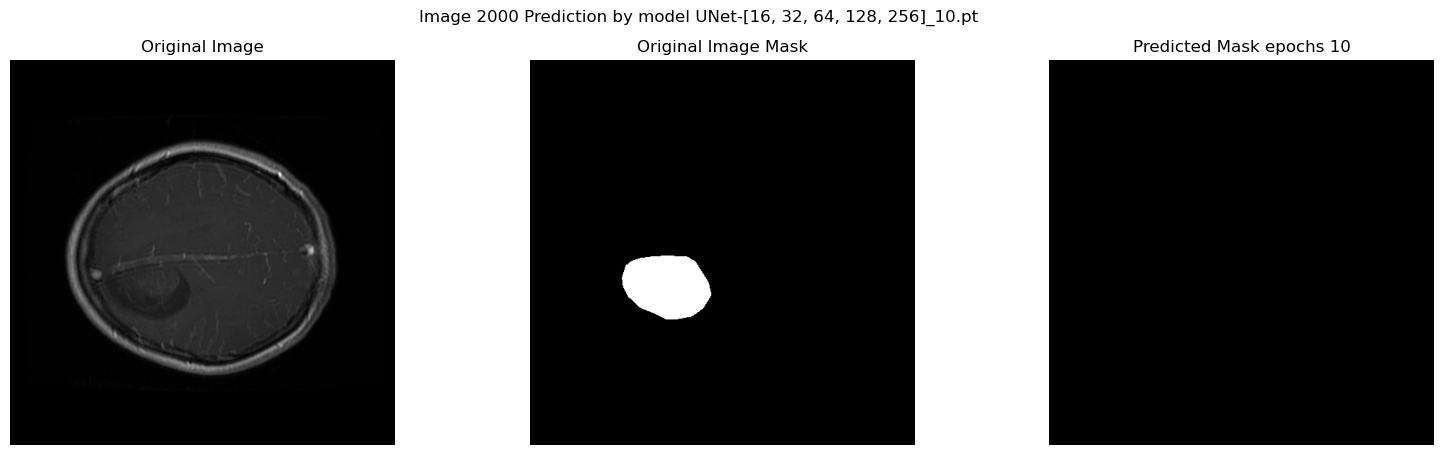

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_100.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2000_predicted.png


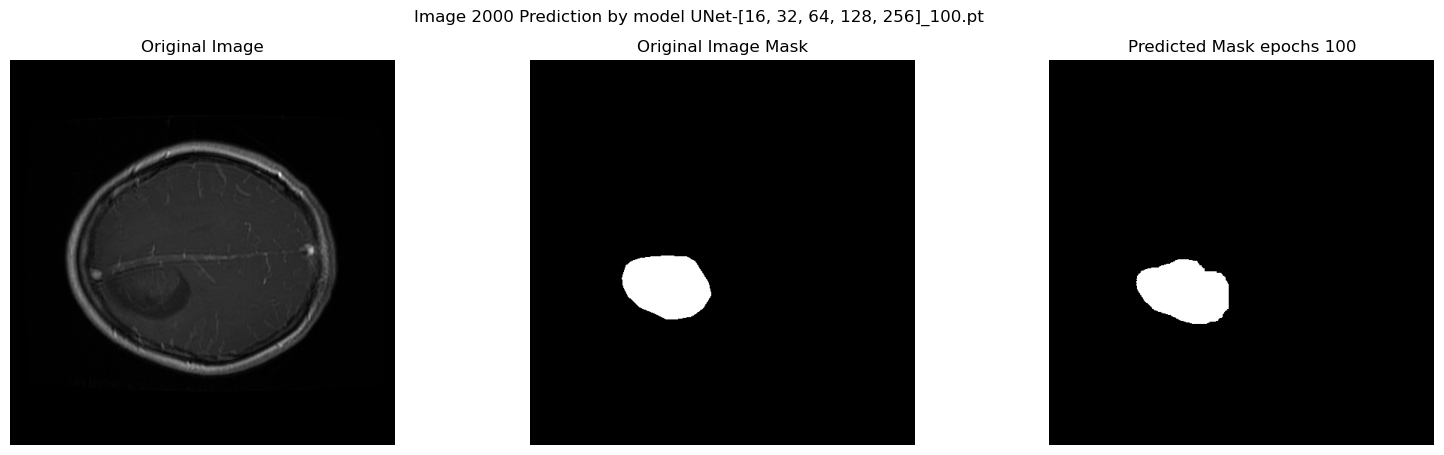

In [12]:
plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_2.pt"
! python api.py --ep 2 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 2000

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 2")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_10.pt"
! python api.py --ep 10 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 10")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_100.pt"
! python api.py --ep 100 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions


org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 100")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_2.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png


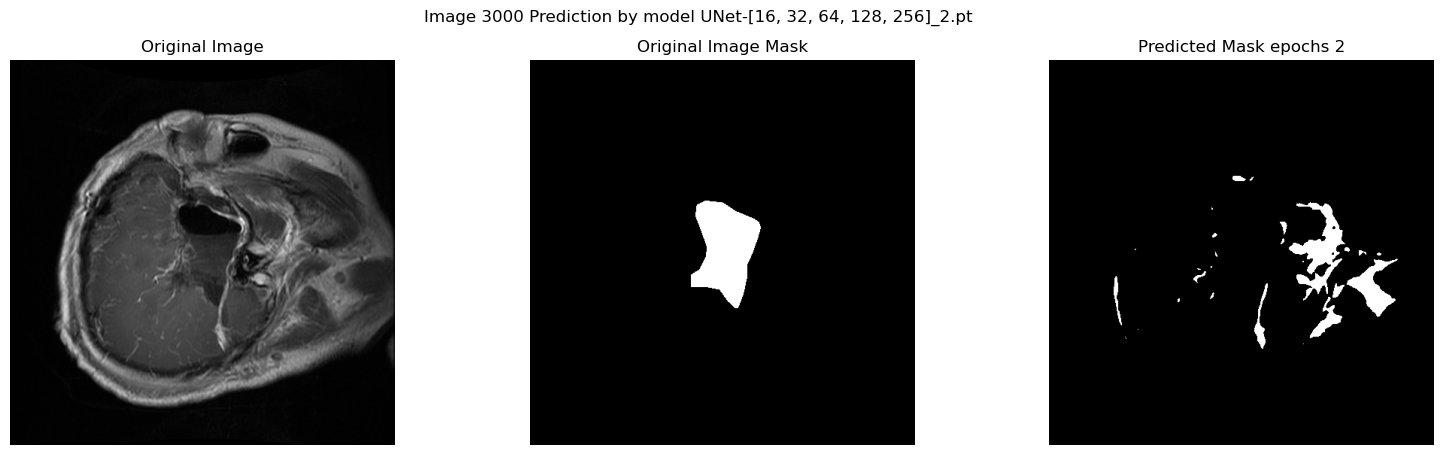

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_10.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png


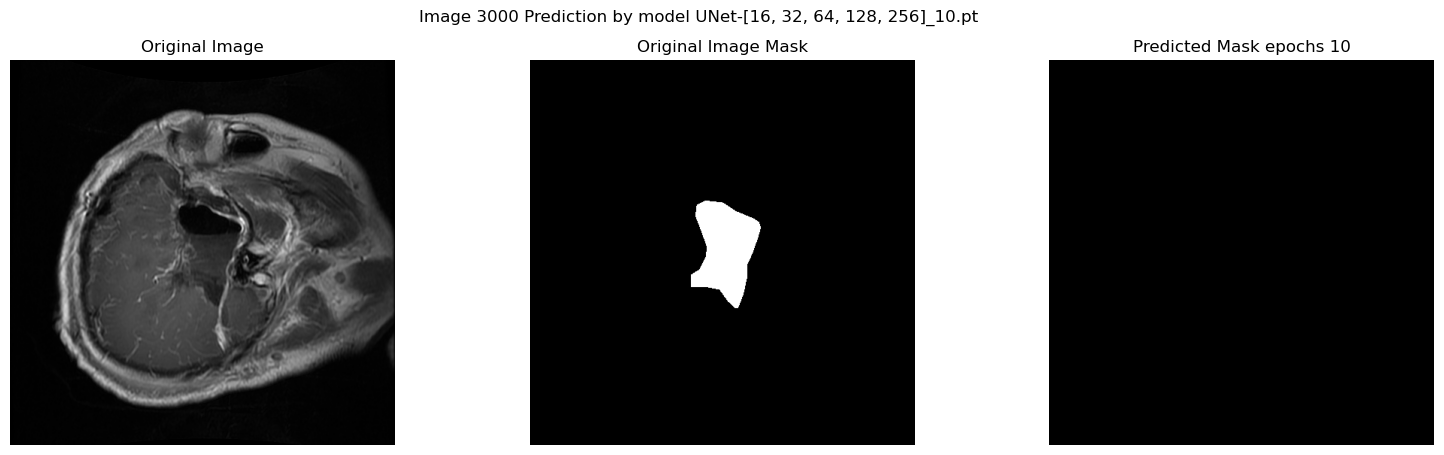

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_100.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/3000_predicted.png


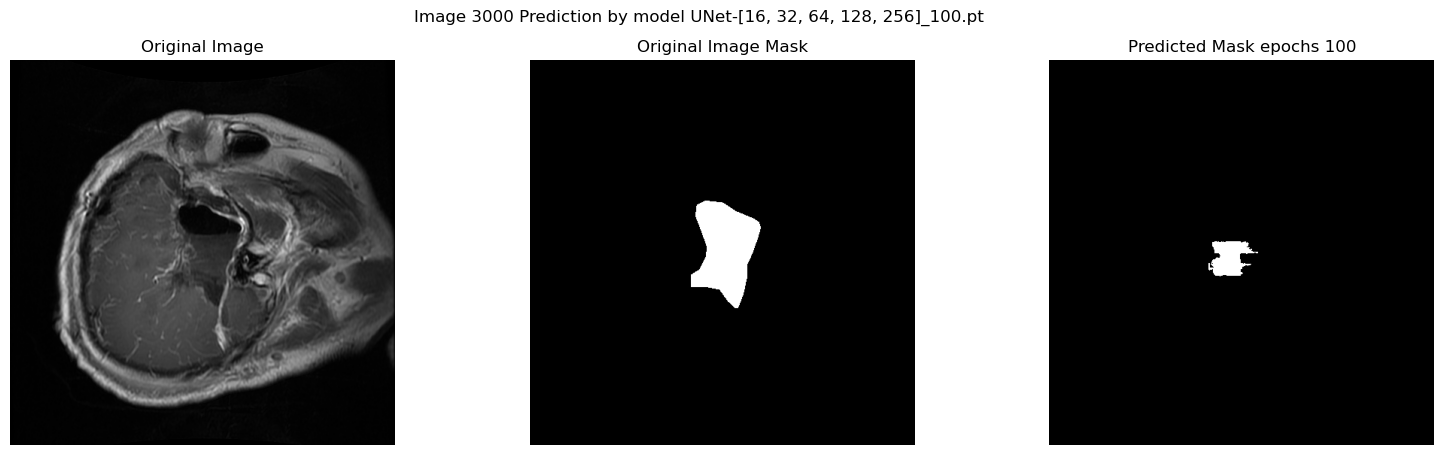

In [13]:
plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_2.pt"
! python api.py --ep 2 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/3000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 3000

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 2")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_10.pt"
! python api.py --ep 10 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/3000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 10")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_100.pt"
! python api.py --ep 100 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/3000.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions


org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask epochs 100")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_2.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png


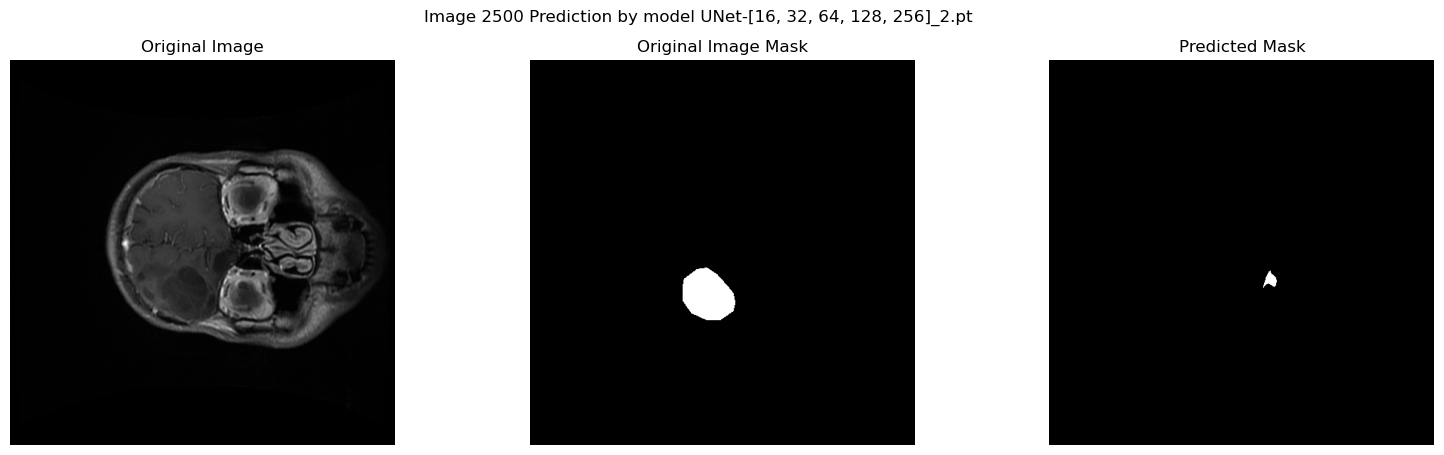

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_10.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png


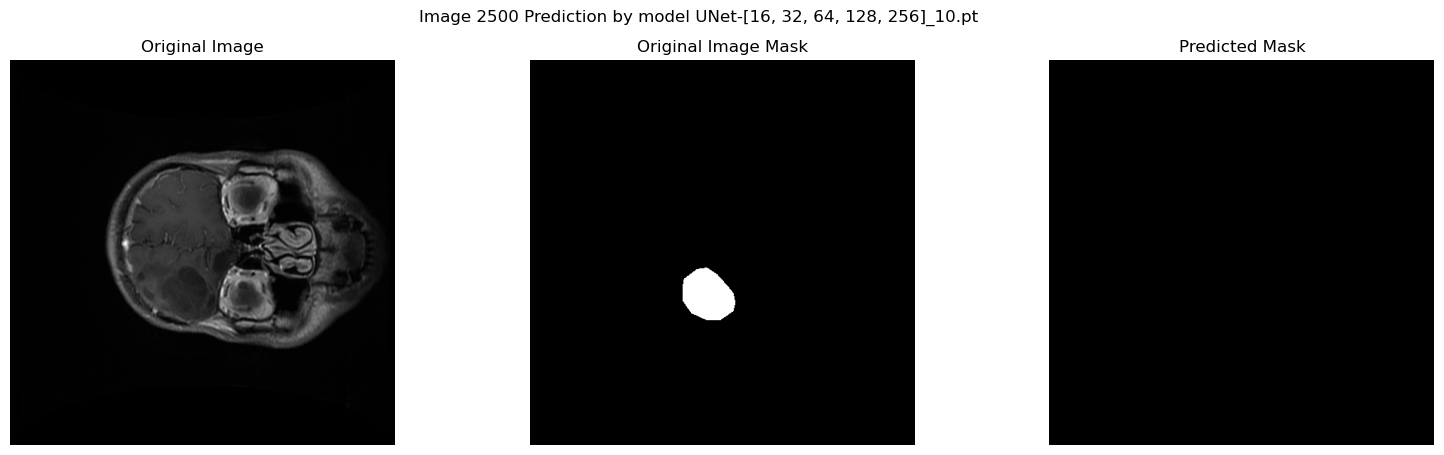

/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/23m1521/.conda/envs/cuda_env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Saved model at location "saved_models/UNet-[16, 32, 64, 128, 256]_100.pt" loaded on cuda
save_path: /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png
Output Image Saved At /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/2500_predicted.png


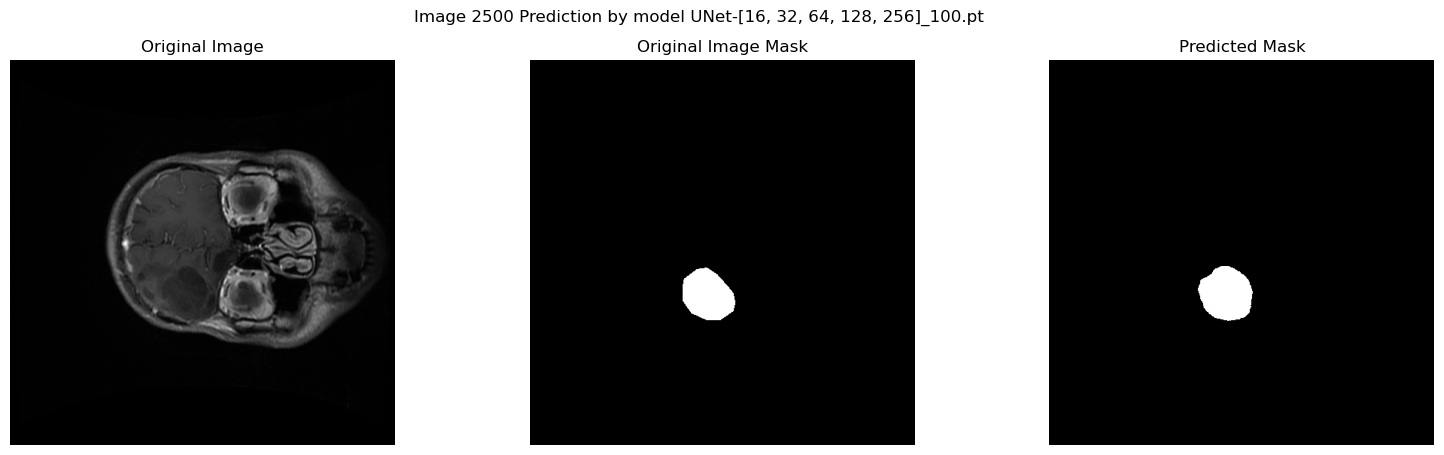

In [14]:
plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_2.pt"
! python api.py --ep 2 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2500.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions
img_num = 2500

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_10.pt"
! python api.py --ep 10 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2500.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions

org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()


plt.figure(figsize=(19,5))
MODEL_NAME = "UNet-[16, 32, 64, 128, 256]_100.pt"
! python api.py --ep 100 --file /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/2500.png --ofp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions


org_img       = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}.png")
org_img_mask  = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/dataset/png_dataset/{img_num}_mask.png")
pred_img      = plt.imread(f"/home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/{img_num}_predicted.png")

plt.subplot(1,3,1)
plt.imshow(org_img, cmap='grey'); plt.axis(False); plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(org_img_mask, cmap='grey'); plt.axis(False); plt.title("Original Image Mask")
plt.subplot(1,3,3)
plt.imshow(pred_img, cmap='grey'); plt.axis(False); plt.title("Predicted Mask")

plt.suptitle(f"Image {img_num} Prediction by model {MODEL_NAME}")
plt.show()

In [15]:
# ! python api.py --dir /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/setup_scripts/test_img --odp /home/23m1521/ashish/Seminar/Brain-Tumor-Segmentation/predictions/test_pred

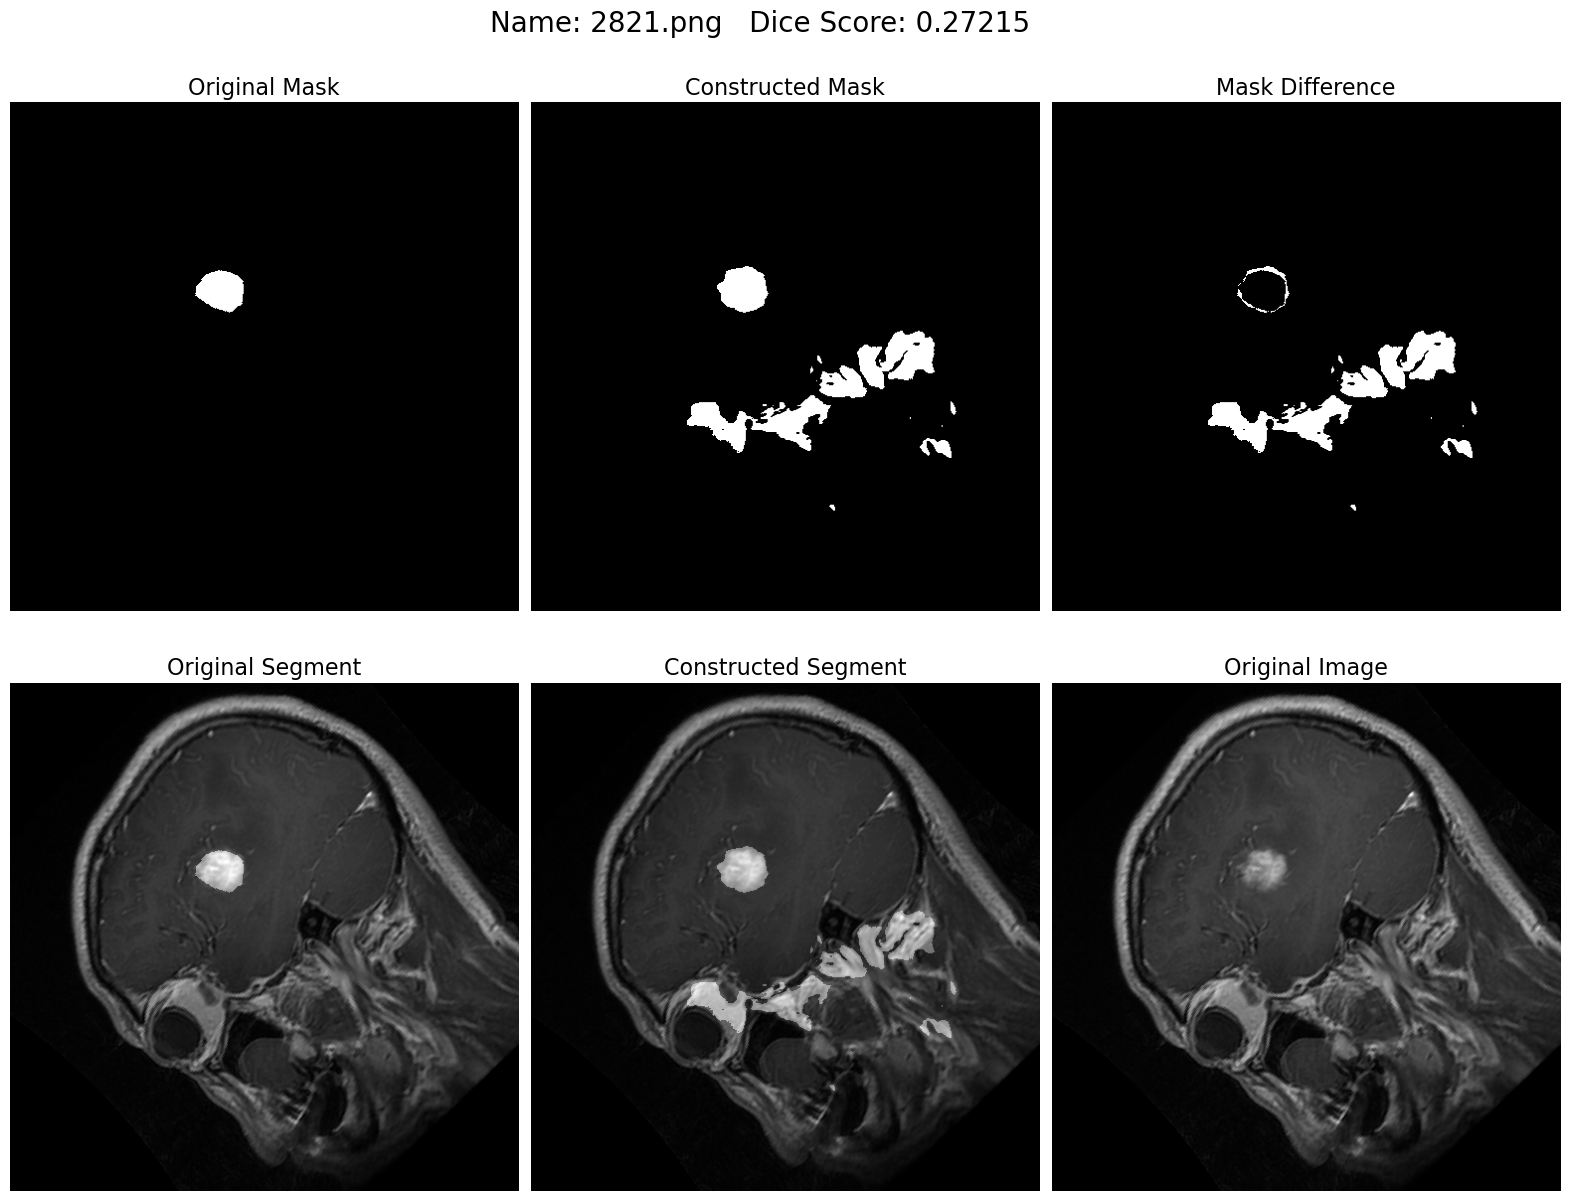

In [16]:
i=176
image_index = test_indices[i]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_classifier.predict(sample,0.65)
title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'

# save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
plot.result(image,mask,output,title,save_path=None)
i += 1
if i >= len(test_indices):
    i = 0

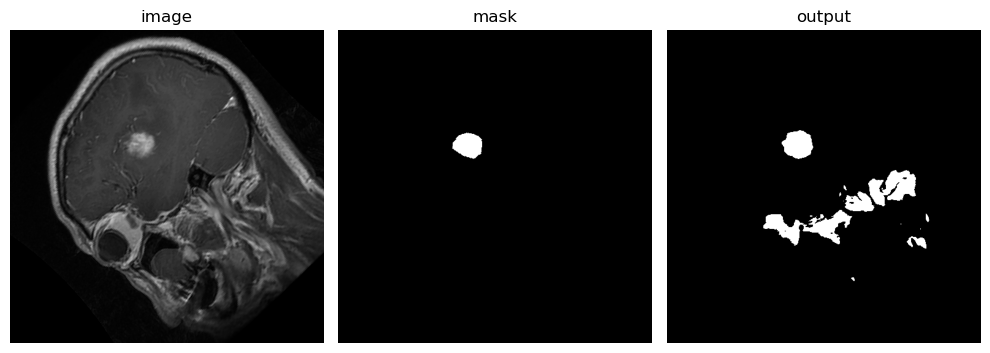

In [36]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.imshow(image, cmap='grey'); plt.axis(False); plt.title("image")
plt.subplot(1,3,2)
plt.imshow(mask, cmap='grey'); plt.axis(False); plt.title("mask")
plt.subplot(1,3,3)
plt.imshow(output, cmap='grey'); plt.axis(False); plt.title("output")
plt.tight_layout()

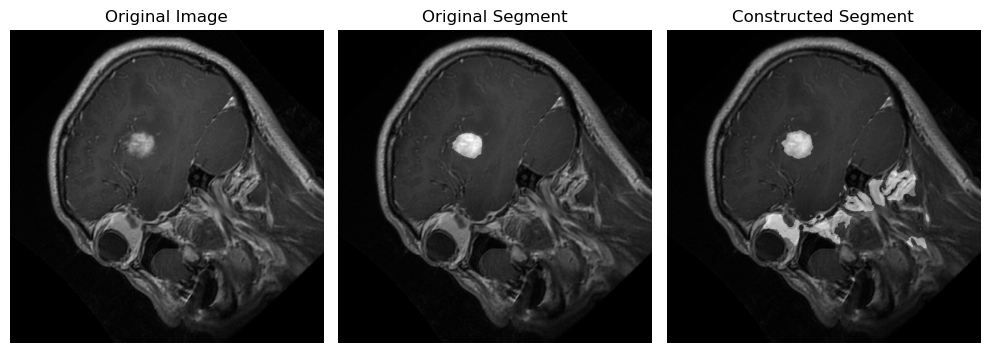

In [41]:
transparency=0.38
plt.figure(figsize=(10,5))


plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis(False)

plt.subplot(1,3,2)
seg_output = mask*transparency
seg_image = np.add(image, seg_output)/2
plt.title("Original Segment")
plt.imshow(seg_image, cmap='gray')
plt.axis(False)


plt.subplot(1,3,3)
seg_output = output*transparency
seg_image = np.add(image, seg_output)/2
plt.title("Constructed Segment")
plt.imshow(seg_image, cmap='gray')
plt.axis(False)

plt.tight_layout()